In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append("..")
from results import get_df, get_stats, final_plot
import input_pipeline
import pandas as pd
import seaborn as sns

plt.rcParams['figure.dpi'] = 300

# Sampling

In [14]:
def sample(num_examples_to_generate, model, temp_vector, latent_dim = 200):
    random_mean = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    z_t = tf.concat([z, temp_vector], axis=1)
    predictions = model.sample(z_t)
    return predictions

def load_model_weights(path, latent_dim = 200, num_classes = 11):
    model = CVAE(latent_dim, num_classes)
    img = tf.zeros((1, 32, 32, 1))
    temp = tf.zeros((1, num_classes))
    dummy_input = (img, temp)
    model(dummy_input)
    model.load_weights(path)
    return model

In [15]:
class CVAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, num_classes,  kernel_size = 3):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim+num_classes,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="SAME"),
        ]
    )

  def call(self, inputs):
    image, temp = inputs
    mean, logvar = self.encode(image)
    z = self.reparameterize(mean, logvar)
    z = tf.concat([z, temp], axis=1)
    reconstructed = self.decode(z)
    return reconstructed

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  image, temp = x
  mean, logvar = model.encode(image)
  z = model.reparameterize(mean, logvar)
  z_t = tf.concat([z, temp], axis=1)
  x_logit = model.decode(z_t)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=image)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [3]:
from tensorflow.keras.models import load_model

classifier = load_model("results/classifier")
classifier.summary()

2024-03-14 11:10:32.880447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30955 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0

In [17]:
temps = [1.5, 2.0, 2.5, 2.7, 3.0, 4.0]
model = load_model_weights("../../GetData/Python/Data/Results/cvae/2024-03-14_10-46/cvae.h5", 200,len(temps))

Text(0.5, 0.98, 'Ising configurations generated by CVAE model')

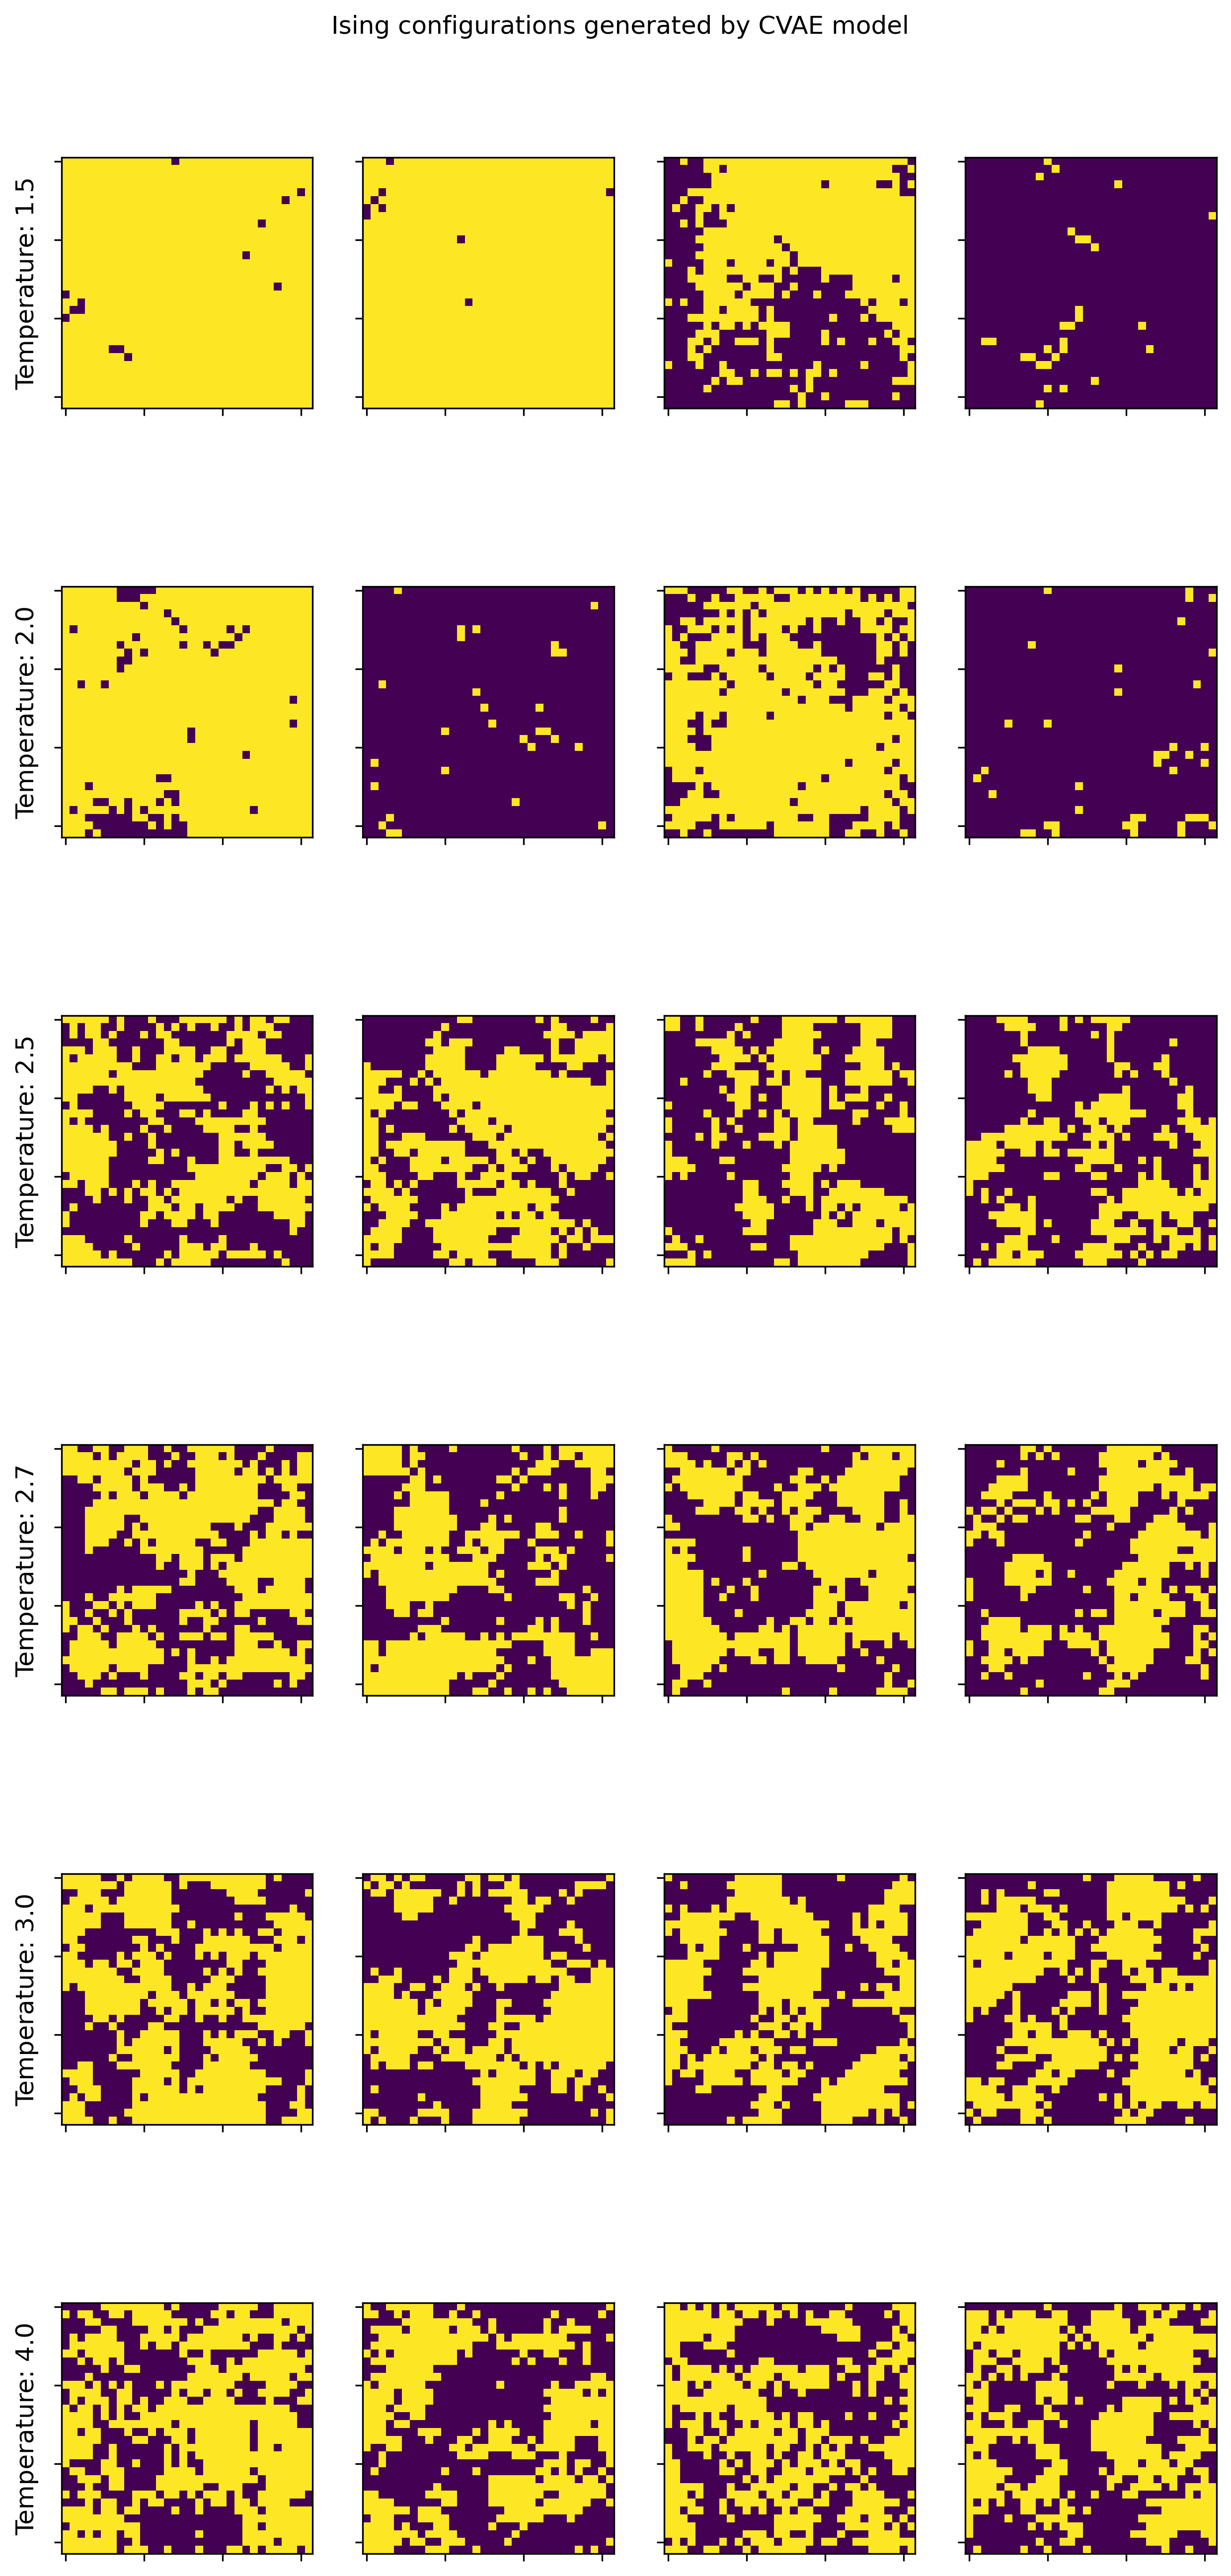

In [19]:
fig, axes = plt.subplots(nrows=len(temps), ncols=4, figsize=(10, 20))
titles = [f"Temperature: {t:.2}" for t in temps]

plt.subplots_adjust(top=0.95)  # Add space at the top

for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(titles[i], rotation=90, size='large')
    temp_vector = np.zeros((5, len(temps)))
    temp_vector[:, i] = 1
    predictions = sample(5, model, temp_vector)
    for j, ax in enumerate(ax_row):
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[j, :, :])
        ax.imshow(spins, vmin=0, vmax=1)

plt.suptitle("Ising configurations generated by CVAE model")


In [20]:
data_list = []
for i, temp in enumerate(temps):
    # Monte Carlo
    trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
    batch_size = 10000
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    data_mc = next(iter(train_set))
    data_mc = 2 * data_mc - 1
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))

    # Sampled from CVAE
    temp_vector = np.zeros((100, len(temps)))
    temp_vector[:, i] = 1
    sample_data = []
    for _ in range(100):
        sample_data.append(sample(100, model, temp_vector))
    spin_sample = tf.concat(sample_data, axis = 0)
    spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
    logits = classifier(spin_sample)
    class_predicted = tf.math.argmax(logits, axis = 1)
    correct_sample = spin_sample[class_predicted == i]
    df_sampled = get_df(correct_sample)
    sample_stats = get_stats(df_sampled, temp)
    sample_stats.extend((temp, "Sampled CVAE"))
    data_list.append(mc_stats)
    data_list.append(sample_stats)

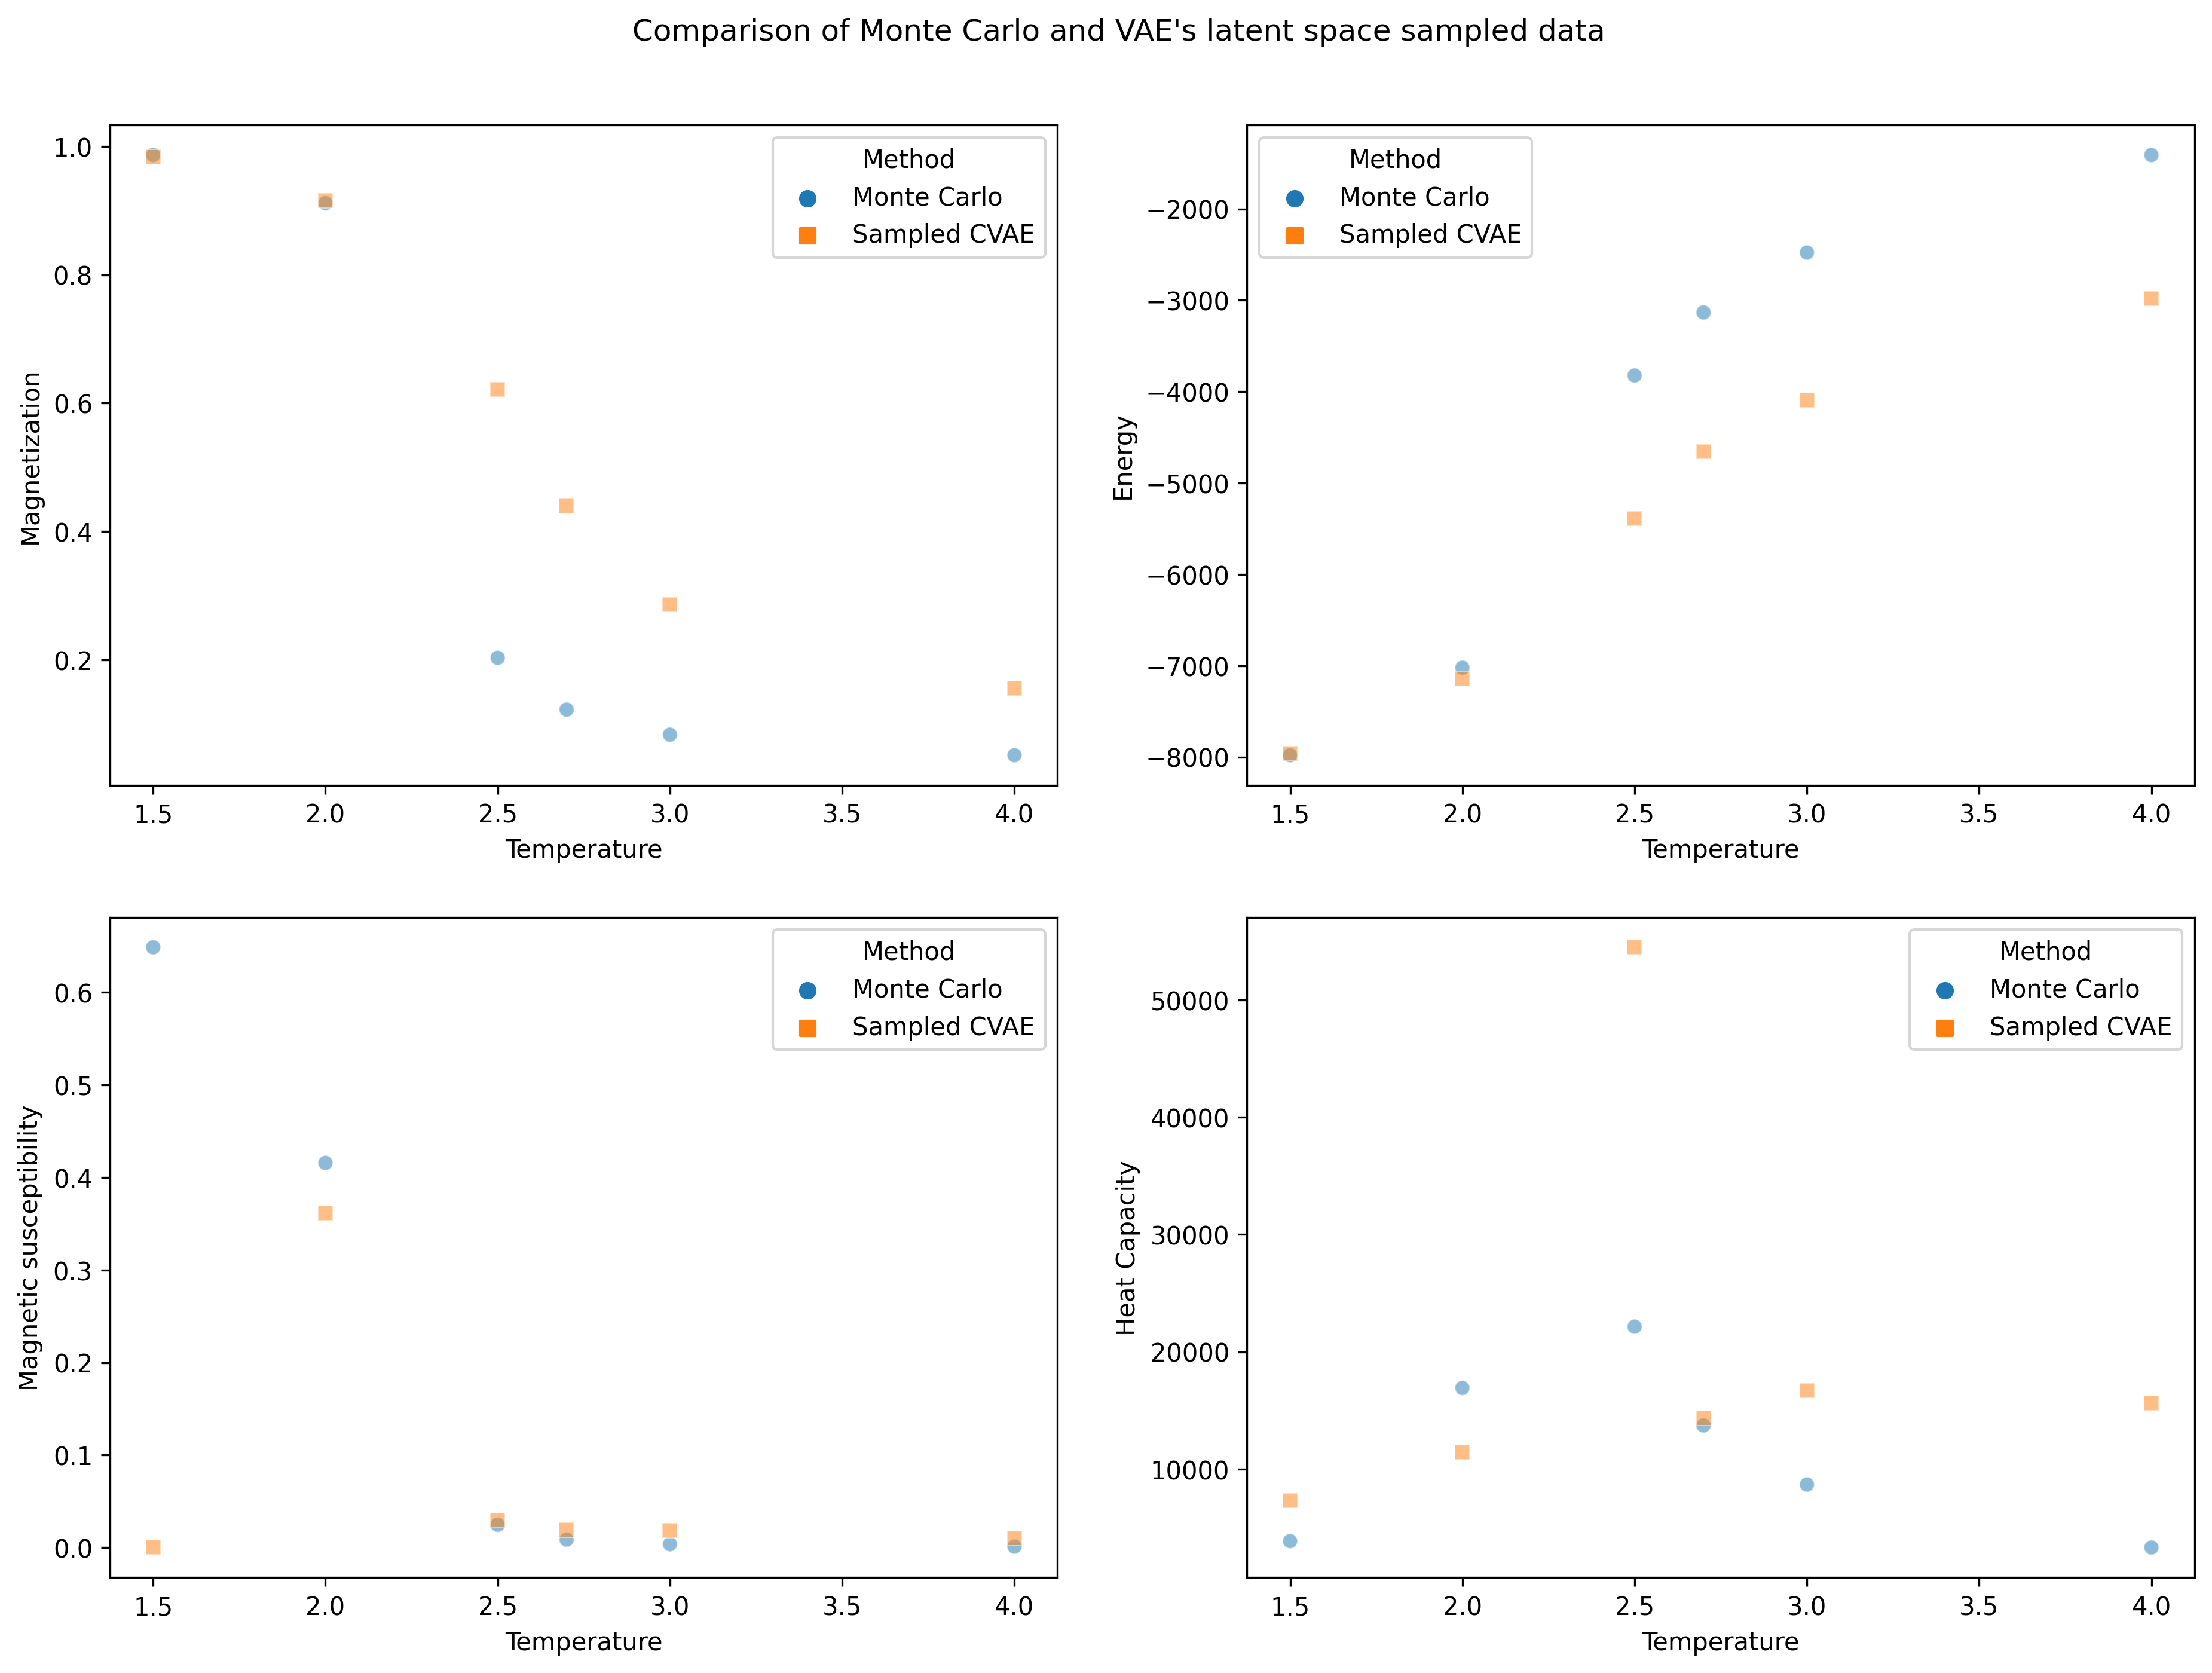

In [21]:
final_plot(data_list)
plt.savefig("cvae_result.png")